In [84]:
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input, decode_predictions 
#from tensorflow.keras.applications. import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow import keras

## Load images into `keras`

In [85]:
# folder names containing images of the things you want to classify
classes=["book","coin","cup","cutlery","face","gesture","glass","nail_polish","pen","plant","plate","shoe"]
# plug in the path to your data folder
base_path ='Project9_pictures/'

In [86]:

data_gen = image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=preprocess_input, validation_split=0.2
     #rotation_range=45,
     #width_shift_range=0.2,
     #height_shift_range=0.2,
     #horizontal_flip=True, 
     #vertical_flip=True,
    #zoom_range=0.2,
    # shear_range=0.2    
)

In [87]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=30,
        target_size=(224, 224),
        subset='training'
)

Found 1030 images belonging to 12 classes.


In [88]:
# a generator that returns batches of X and y arrays
train_data_gen_val = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=30,
        target_size=(224, 224),
        subset='validation'
)

Found 249 images belonging to 12 classes.


In [89]:
# first 30 images , each time you rerun this the next set of 30 images will be displayed
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((30, 224, 224, 3), (30, 12))

In [90]:
def plotImages(images_arr):
    fig, axes = plt.subplots(6, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

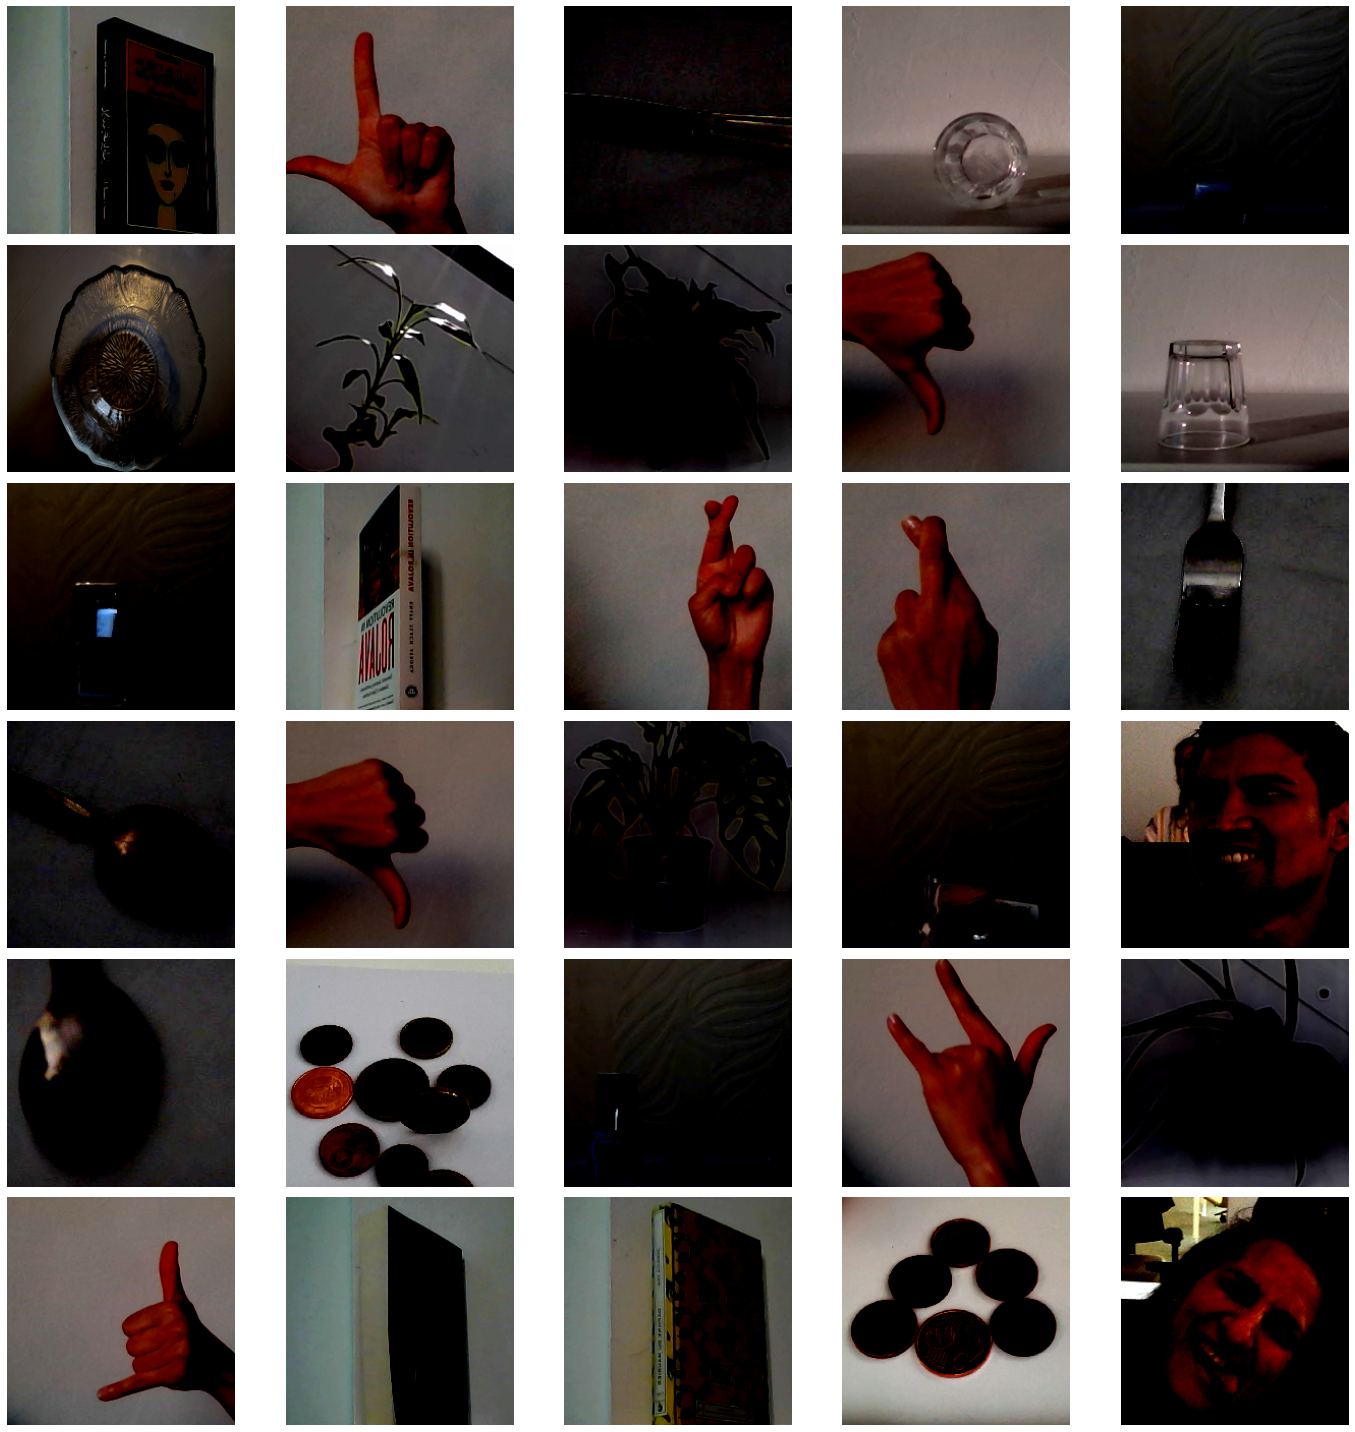

In [91]:
plotImages(xtrain)

In [92]:
classes

['book',
 'coin',
 'cup',
 'cutlery',
 'face',
 'gesture',
 'glass',
 'nail_polish',
 'pen',
 'plant',
 'plate',
 'shoe']

In [93]:
ytrain[0:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [94]:
xtrain.shape

(30, 224, 224, 3)

## Create CNN Model

### 1. Select the convolutional base 

In [95]:
# Transfer learning on MobileNet model
from tensorflow.keras.applications import mobilenet_v2
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

### 2. Freeze the weights

In [96]:
# freeze it! , for making use of the weights that were already obtained with the pretrained model and to not retrain it again 
base_model.trainable = False

### 3. Add your own dense layers on top

In [97]:
model = keras.Sequential() # defining a new model
model.add(base_model) # adding in the pretrained model without the fully connected layer
#model.add(keras.layers.Dense(100, activation='relu')) # adding in additional layers
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 425,580
Trainable params: 15,372
Non-trainable params: 410,208
_________________________________________________________________


In [98]:
len(classes)

12

### 4. Compile and train!

In [99]:
from tensorflow.keras import backend as K

K.clear_session()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history=model.fit(train_data_gen, validation_data = train_data_gen_val, epochs=50, verbose=2,callbacks=[callback])
          #batch_size=100, 
          
          # use 30% of the data for validation

Epoch 1/50
35/35 - 30s - loss: 1.3493 - categorical_accuracy: 0.6049 - val_loss: 0.4149 - val_categorical_accuracy: 0.9277 - 30s/epoch - 844ms/step
Epoch 2/50
35/35 - 14s - loss: 0.2698 - categorical_accuracy: 0.9495 - val_loss: 0.1930 - val_categorical_accuracy: 0.9799 - 14s/epoch - 405ms/step
Epoch 3/50
35/35 - 13s - loss: 0.1407 - categorical_accuracy: 0.9718 - val_loss: 0.1444 - val_categorical_accuracy: 0.9799 - 13s/epoch - 367ms/step
Epoch 4/50
35/35 - 13s - loss: 0.0999 - categorical_accuracy: 0.9796 - val_loss: 0.1219 - val_categorical_accuracy: 0.9839 - 13s/epoch - 383ms/step
Epoch 5/50
35/35 - 13s - loss: 0.0694 - categorical_accuracy: 0.9883 - val_loss: 0.1080 - val_categorical_accuracy: 0.9880 - 13s/epoch - 358ms/step
Epoch 6/50
35/35 - 12s - loss: 0.0496 - categorical_accuracy: 0.9961 - val_loss: 0.1009 - val_categorical_accuracy: 0.9799 - 12s/epoch - 345ms/step
Epoch 7/50
35/35 - 12s - loss: 0.0417 - categorical_accuracy: 0.9990 - val_loss: 0.0894 - val_categorical_accura

## Evaluation

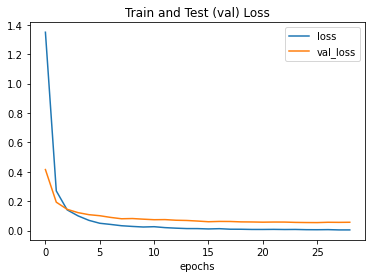

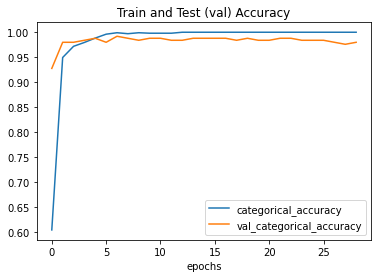

In [113]:
import pandas as pd
losses_accurs = pd.DataFrame(history.history)

losses_accurs[['loss', 'val_loss']].plot()
plt.gcf().set_facecolor('white')
plt.title('Train and Test (val) Loss')
plt.xlabel('epochs')
plt.show()

losses_accurs[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.gcf().set_facecolor('white')
plt.title('Train and Test (val) Accuracy')
plt.xlabel('epochs')
plt.show()

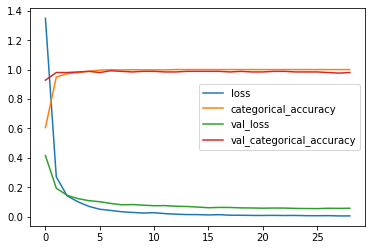

In [114]:
# Plot model accuracy and loss:
pd.DataFrame(history.history).plot()
plt.gcf().set_facecolor('white')

In [115]:
losses_accurs

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,1.349261,0.604854,0.414939,0.927711
1,0.269777,0.949515,0.193032,0.979920
2,0.140680,0.971845,0.144434,0.979920
3,0.099938,0.979612,0.121897,0.983936
4,0.069439,0.988349,0.108017,0.987952
5,0.049565,0.996117,0.100924,0.979920
6,0.041652,0.999029,0.089401,0.991968
7,0.032777,0.997087,0.080158,0.987952
8,0.028036,0.999029,0.081698,0.983936
9,0.024094,0.998058,0.077414,0.987952


In [116]:
# evaluate the model and print the results
losses_accurs.iloc[-1]

loss                        0.004311
categorical_accuracy        1.000000
val_loss                    0.056404
val_categorical_accuracy    0.979920
Name: 28, dtype: float64

In [117]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (18,6))
    plt.gcf().set_facecolor('white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [138]:
"""from sklearn.metrics import confusion_matrix
predictions = model.predict(x=train_data_gen_val, verbose=0)
cm = confusion_matrix(y_true=train_data_gen_val.classes, \
                      y_pred=np.argmax(predictions, axis=-1))

cm_plot_labels = ["book","coin","cup","cutlery","face","gesture","glass","nail_polish","pen","plant","plate","shoe"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')"""

'from sklearn.metrics import confusion_matrix\npredictions = model.predict(x=train_data_gen_val, verbose=0)\ncm = confusion_matrix(y_true=train_data_gen_val.classes,                       y_pred=np.argmax(predictions, axis=-1))\n\ncm_plot_labels = ["book","coin","cup","cutlery","face","gesture","glass","nail_polish","pen","plant","plate","shoe"]\nplot_confusion_matrix(cm=cm, classes=cm_plot_labels, title=\'Confusion Matrix\')'

In [126]:
# serialize model
model.save("models/model_mobilnet.h5")
print("Saved model to disk")

Saved model to disk


### Testing Model

In [127]:
from tensorflow.keras.models import load_model
network = load_model("models/model_mobilnet.h5")

In [128]:
dic={0:"book",1:"coin",2:"cup",3:"cutlery",4:"face",5:"gesture",6:"glass",7:"nail_polish",8:"pen", 9:"plant", 10:"plate", 11:"shoe"}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


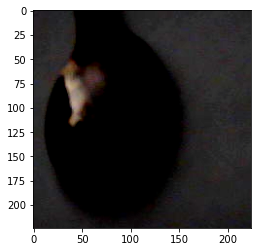

In [137]:
plt.imshow(xtrain[20])

In [130]:
image_reshaped=xtrain[5].reshape(1,224,224,3)
network.predict(image_reshaped)

array([[7.95946326e-05, 1.09812834e-04, 1.41373221e-05, 7.85434895e-05,
        4.41850307e-06, 5.90953232e-06, 4.08249180e-04, 1.58933282e-04,
        9.03293937e-07, 2.55576197e-05, 9.99111950e-01, 1.95777852e-06]],
      dtype=float32)

In [131]:
item_class=np.argmax(network.predict(image_reshaped))
item_class

10

In [132]:


print("The shape is:     "+dic[item_class])

The shape is:     plate
